In [688]:
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import seaborn as sns


import imblearn
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline


from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, ValidationCurveDisplay, validation_curve
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import log_loss, classification_report, f1_score, accuracy_score
from sklearn.pipeline import Pipeline


import phik
from phik.report import plot_correlation_matrix
from phik import report

In [610]:
df = pd.read_csv(r'C:\Users\Nikita Krotkov\Desktop\Новая папка\healthcare-dataset-stroke-data.csv')

In [611]:
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [612]:
df.isna().mean().sort_values(ascending=False) # посмотрим количество пропусков

bmi                  0.039335
id                   0.000000
gender               0.000000
age                  0.000000
hypertension         0.000000
heart_disease        0.000000
ever_married         0.000000
work_type            0.000000
Residence_type       0.000000
avg_glucose_level    0.000000
smoking_status       0.000000
stroke               0.000000
dtype: float64

In [613]:
df.dropna(inplace=True)  # пропуски только у bmi (4%), поэтому можем спокойно их удалить

df.drop('id', axis=1, inplace=True) # id пациента не информативны

df = df.reset_index()


In [615]:
# КОДИРОВКА КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ

df['ever_married'].replace('No', 0, inplace=True) # 0 если был
df['ever_married'].replace('Yes', 1, inplace=True) # 1 если НЕ был

df['gender'].replace('Female', 0, inplace=True) # 0 если Female
df['gender'].replace('Male', 1, inplace=True) # 1 если Male

df['Residence_type'].replace('Urban', 0, inplace=True) # 0 если Urban
df['Residence_type'].replace('Rural', 1, inplace=True) # 1 если Rural

# Корреляционный анализ показал, что в признаке smoking_status существует сильная линейная корреляция между 'Unknown' и 'never smoked'. Поэтому, их можно объединить
df['smoking_status'].replace('Unknown', 'never smoked', inplace=True)

## БАЛАНСИРОВКА И СТАНДАРТИЗАЦИЯ ДАННЫХ ДАННЫХ

In [616]:
df = pd.get_dummies(df, columns = ["work_type", "Residence_type", "smoking_status"], drop_first=True)
df.drop('index', axis= 1, inplace=True )

In [617]:
# Стандартизация данных

stan = StandardScaler()
columns = ["age", "avg_glucose_level", "bmi"]
df[columns] = stan.fit_transform(df[columns])

c:\Users\Nikita Krotkov\.conda\envs\da_env\Lib\site-packages\seaborn\matrix.py:260: FutureWarning:

Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior



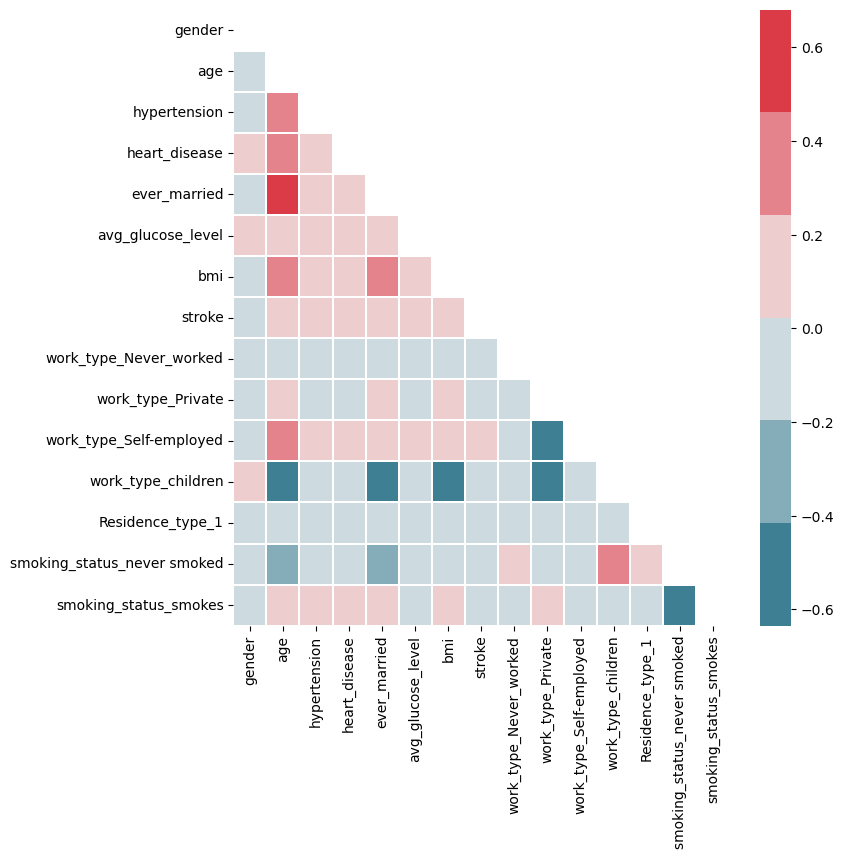

In [618]:
# ЛИНЕЙНый КОРРЕЛЯЦИОННЫЙ АНАЛИЗ ПРИЗНАКОВ

corr1 = df.corr()
mask = np.zeros_like(corr1, dtype=bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(8, 8)) #создание графика и определение его размеров
cmap = sns.diverging_palette(220, 10) #создание палитры для корреляционного графика
sns.heatmap(corr1, cmap=cmap, linewidths=.2, mask=mask, annot=True, fmt=".2f") 
plt.show()

interval columns not set, guessing: ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'avg_glucose_level', 'bmi', 'stroke']


c:\Users\Nikita Krotkov\.conda\envs\da_env\Lib\site-packages\seaborn\matrix.py:260: FutureWarning:

Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior



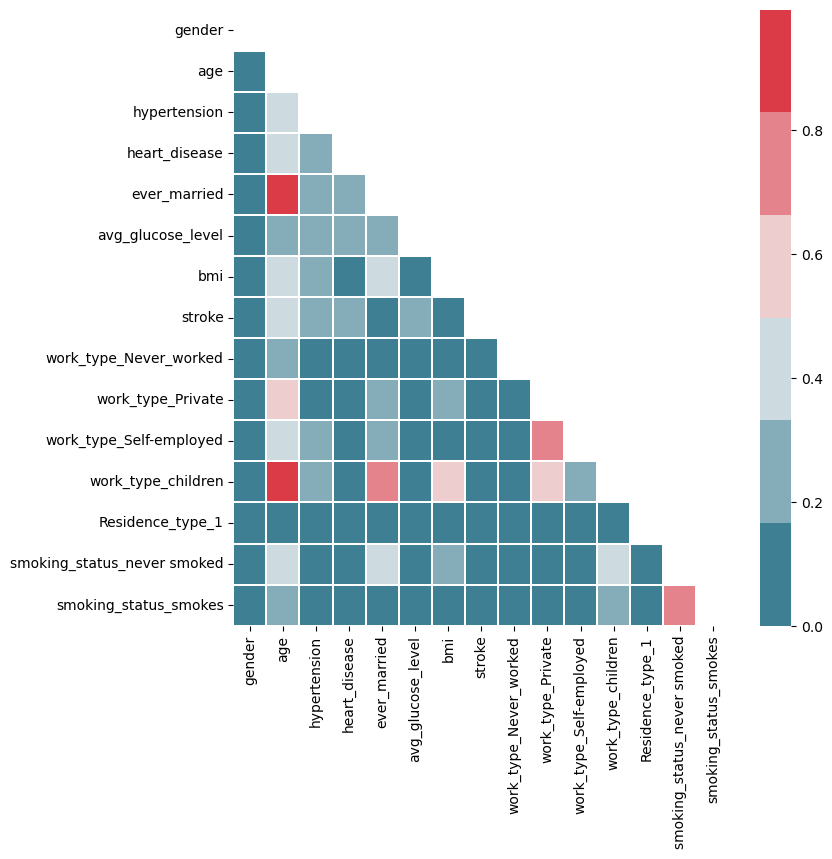

In [692]:
# НЕЛИНЕЙНый КОРРЕЛЯЦИОННЫЙ АНАЛИЗ ПРИЗНАКОВ

corr1 = df.phik_matrix()
mask = np.zeros_like(corr1, dtype=bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(8, 8)) #создание графика и определение его размеров
cmap = sns.diverging_palette(220, 10) #создание палитры для корреляционного графика
sns.heatmap(corr1, cmap=cmap, linewidths=.10, mask=mask, annot=True, fmt=".2f") 
plt.show()

## БАЛАНСИРОВКА КЛАССОВ

In [693]:
# разделение на трейн, тест

X = df.drop('stroke', axis=1)
y = df['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41, shuffle=True)

In [621]:
# БАЛАНСИРОВКА КЛАССОВ В ТРЕНИРОВОЧНЫХ ДАННЫХ

over = SMOTE()
X_train_resh, y_train_resh = over.fit_resample(X_train, y_train.ravel())

## ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ

In [672]:
logit = LogisticRegression(random_state=7, solver='saga', penalty=None).fit(X_train, y_train)
logit.feature_names_in_

c:\Users\Nikita Krotkov\.conda\envs\da_env\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



array(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'avg_glucose_level', 'bmi', 'work_type_Never_worked',
       'work_type_Private', 'work_type_Self-employed',
       'work_type_children', 'Residence_type_1',
       'smoking_status_never smoked', 'smoking_status_smokes'],
      dtype=object)

<Axes: ylabel='Feature'>

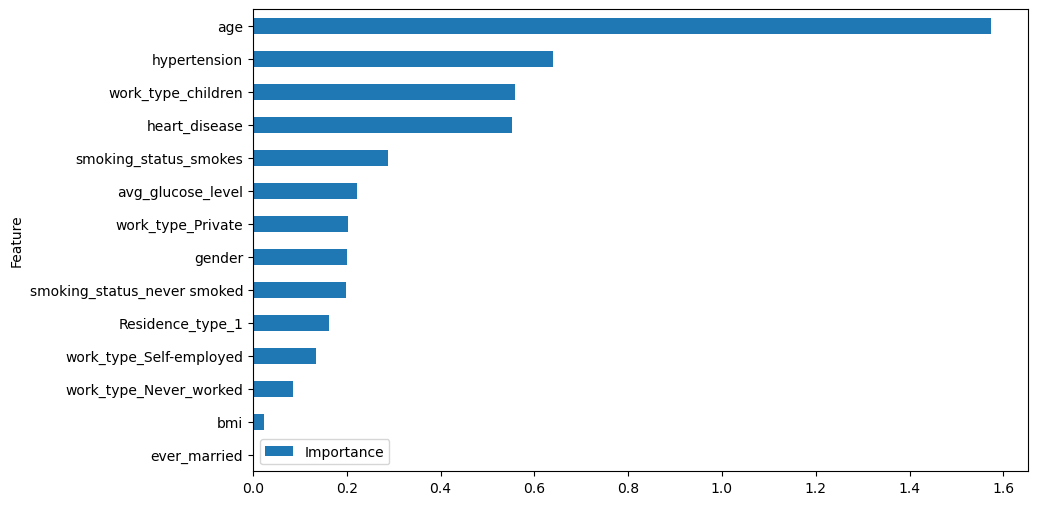

In [673]:
coefficients = logit.coef_[0]

feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

In [674]:
logreg_pipeline = Pipeline(steps=[('scale', StandardScaler()), ('LR', LogisticRegression(penalty=None, random_state=42))])

logreg_cv = cross_val_score(logreg_pipeline, X_train_resh, y_train_resh, cv=10, scoring='f1')

print('Logistic Regression mean :', cross_val_score(logreg_pipeline, X_train_resh, y_train_resh, cv=10, scoring='f1').mean())

Logistic Regression mean : 0.8008322401533985


In [678]:
logreg_pipeline.fit(X_train_resh, y_train_resh)
logreg_pred  = logreg_pipeline.predict(X_test)

print(classification_report(y_test, logreg_pred))

print('Accuracy Score: ',accuracy_score(y_test, logreg_pred))
print('F1 Score: ',f1_score(y_test,logreg_pred))

              precision    recall  f1-score   support

           0       0.98      0.75      0.85       937
           1       0.13      0.76      0.22        45

    accuracy                           0.75       982
   macro avg       0.56      0.75      0.53       982
weighted avg       0.95      0.75      0.82       982

Accuracy Score:  0.7505091649694501
F1 Score:  0.21725239616613418


## L2 РЕГУЛЯРИЗАЦИЯ

In [681]:
penalty = ['l2']
C = np.linspace(1e-4, 100, 1000)

log_param_grid = {'penalty': penalty, 
                  'C': C}

logreg = LogisticRegression(random_state=42)
grid = GridSearchCV(logreg, log_param_grid).fit(X_train_resh,y_train_resh)

In [684]:
grid.best_params_

{'C': 9.4095, 'penalty': 'l2'}

In [685]:
logreg_pipeline = Pipeline(steps = [('scale',StandardScaler()),('LR',LogisticRegression(C=0.1,penalty='l2',random_state=42))]).fit(X_train_resh,y_train_resh)

logreg_pipeline.fit(X_train_resh,y_train_resh)

logreg_tuned_pred   = logreg_pipeline.predict(X_test)


In [686]:
print(classification_report(y_test, logreg_tuned_pred_l2))

print('Accuracy Score: ', accuracy_score(y_test, logreg_tuned_pred_l2))
print('F1 Score: ', f1_score(y_test, logreg_tuned_pred_l2))

              precision    recall  f1-score   support

           0       0.98      0.75      0.85       937
           1       0.13      0.76      0.22        45

    accuracy                           0.75       982
   macro avg       0.56      0.75      0.53       982
weighted avg       0.95      0.75      0.82       982

Accuracy Score:  0.7494908350305499
F1 Score:  0.2165605095541401


## L1 РЕГУЛЯРИЗАЦИЯ

## ОПОРНЫЕ ВЕКТОРА (SVC)

In [ ]:
svm_pipeline = Pipeline(steps=[('scale', StandardScaler()), ('SVM', SVC(random_state=42))])

svm_cv = cross_val_score(svm_pipeline, X_train_resh, y_train_resh, cv=10,scoring='f1')

print('SVM mean :', cross_val_score(svm_pipeline, X_train_resh, y_train_resh, cv=10, scoring='f1').mean())

SVM mean : 0.8708687037431814


In [ ]:
svm_param_grid = {'C': [0.1, 1, 10, 100, 1000],  
             'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
             'kernel': ['rbf']} 

svm = SVC(random_state=42)

grid = GridSearchCV(svm,svm_param_grid).fit(X_train_resh, y_train_resh)
grid.best_params_

{'C': 100, 'gamma': 1, 'kernel': 'rbf'}

In [ ]:
svm_pipeline = Pipeline(steps = [('scale',StandardScaler()),('SVM',SVC(C=1000,gamma=0.01,kernel='rbf',random_state=42))])

svm_pipeline.fit(X_train_resh,y_train_resh)

svm_tuned_pred   = svm_pipeline.predict(X_test)

In [ ]:
print(classification_report(y_test, svm_tuned_pred))

print('Accuracy Score: ',accuracy_score(y_test, svm_tuned_pred))
print('F1 Score: ',f1_score(y_test, svm_tuned_pred))

              precision    recall  f1-score   support

           0       0.96      0.84      0.90       937
           1       0.07      0.24      0.11        45

    accuracy                           0.81       982
   macro avg       0.51      0.54      0.50       982
weighted avg       0.92      0.81      0.86       982

Accuracy Score:  0.8126272912423625
F1 Score:  0.10679611650485439
